In [1]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import cross_decomposition
import plotly.express as px 

### Constants

In [2]:
data_url =  "https://raw.githubusercontent.com/Naio/aasa-stability-prediction/master/data/processed/"
#Seed for controlling any random procedure during the experiments
seed = 99

### Defining hyperparameter grids
Each algorithm has its corresponding hyperparameter grid for later use in grid search inner cross-validation loop.

In [3]:
least_squares_grid = {} #Ordinary least square doesn't have hyperparamters

ridge_grid = {'alpha' : np.logspace(-6, 6, 13)} #Alpha between 1.e-06 and 1.e+06
lasso_grid = {'alpha' : np.logspace(-6, 6, 13)} 
pls_grid = {'n_components': np.linspace(start = 2, stop=25, num=24).astype(int)} #Between 2 and 25 Principal Components

svr_grid = [
    #Grid for linear kernel
    {'C': np.logspace(-6, 6, 13), 'kernel': ['linear']},
    #Grid for rbf and sigmoid kernel
    {'C': np.logspace(-6, 6, 13), 'gamma': np.logspace(-6, 6, 13), 'kernel': ['rbf', 'sigmoid']},
    #Grid for polinomial kernel
    {'C': np.logspace(-6, 6, 13), 'gamma': np.logspace(-6, 6, 13), 'kernel': ['poly'], 'degree': [2,3,4]}
 ]


### Creating estimators for each learning method

In [4]:
#learning_methods function will create the empty estimators and map them to their corresponding hyperparameter grid.
def get_learning_methods():
    learning_methods = [{'name': 'OLS', 'estimator': linear_model.LinearRegression(), 'hyperparameter_grid': least_squares_grid},
                        {'name': 'RIDGE','estimator':linear_model.Ridge(random_state=seed), 'hyperparameter_grid': ridge_grid},
                        {'name': 'LASSO', 'estimator':linear_model.Lasso(), 'hyperparameter_grid': lasso_grid},
                        {'name': 'PLS', 'estimator':cross_decomposition.PLSRegression(), 'hyperparameter_grid': pls_grid},
                        {'name': 'SVR', 'estimator':svm.SVR(), 'hyperparameter_grid': svr_grid}]
    return learning_methods

### Loading the data

In [5]:
def datasets():
    
    datasets_names = ['A', 'B', 'C', 'D']
    
    for dataset_name in datasets_names:
        protein_dataset = pd.read_csv(data_url + dataset_name + '.csv')
        proteins_X = protein_dataset.iloc[:, 1:].to_numpy()
        proteins_X = preprocessing.scale(proteins_X) #Z-Score standarization
        proteins_y = protein_dataset.iloc[:,0].to_numpy()
        
        yield {'name': dataset_name, 'features': proteins_X, 'target': proteins_y}

### Training and validation

In [6]:
#The nested_cv function returns a dictionary like with the outer cross-validation loop scores for every learning method.
#The dictionary looks like:
#{
#    'r2': {'PLS': [0.99,...,0.67], 'SVR': [0.94,..., 0.98], ... , 'OLS': [0.4, ..., 0.32]}, 
#  'rmse': {'PLS': [1.297116,...,2.297116], 'SVR': [1.291,..., 0.29471], ... , 'OLS': [3.19283, ..., 5.827391]}
#}
def nested_cv(features, target):
    
    #Score metric used for hyperparameter optimization in inner CV loop
    inner_scoring = 'r2'
    
    #Score metrics used in outer CV loop for generalization performance estimation of the learning method 
    outer_scoring = ['r2', 'neg_root_mean_squared_error']
    
    outer_scores_r2 = {}
    outer_scores_rmse = {}
    
    learning_methods = get_learning_methods()
    
    for learning_method in learning_methods:
        inner_cv = KFold(n_splits=10, shuffle=True, random_state=seed)
        outer_cv = KFold(n_splits=10, shuffle=True, random_state=seed)

        #Inner CV estimator
        #When the fit() method is called, it will internally perform a grid search cross-validation. 
        #Once it finds the best hyperparameters, it will fit on complete training set using those parameters.
        est = GridSearchCV(estimator = learning_method['estimator'], 
                           param_grid = learning_method['hyperparameter_grid'], 
                           cv = inner_cv, 
                           scoring = inner_scoring,
                           #When n_jobs is -1, all CPUs are used to run cross-validation in parallel
                           n_jobs=-1)

        #For each train-test dataset split in the outer cross validation loop, 
        #cross_validate function will call the fit() method of the GridSearchCV estimator
        #to fit it on the train set. Once the estimator is fitted, it is used to predict over the test set
        #and calculate the score.
        outer_cv_results = cross_validate(estimator = est, 
                                          X = features, y = target, 
                                          cv = outer_cv, scoring = outer_scoring)
        
        outer_scores_r2[learning_method['name']] = outer_cv_results['test_r2']
        
        #Inside CV, the RSME score is managed as a negative RMSE. Multiplying it by -1 will turn it into the usual positive RMSE  
        outer_scores_rmse[learning_method['name']] = outer_cv_results['test_neg_root_mean_squared_error']*-1 
       
    return {'r2': outer_scores_r2, 'rmse':outer_scores_rmse}


### Running experiments

In [8]:
%%time
results = {}
#For each dataset (A,B,C,D)
for dataset in datasets():
    nested_cv_results = nested_cv(dataset['features'], dataset['target'])
    
    results[dataset['name']] = nested_cv_results
    
    nested_cv_results_df = pd.DataFrame(nested_cv_results['r2'])
    nested_cv_results_df.to_csv(path_or_buf = './RSquared_scores_' + dataset['name'] + '.csv')
    
    nested_cv_results_df = pd.DataFrame(nested_cv_results['rmse'])
    nested_cv_results_df.to_csv(path_or_buf = './RMSE_scores_' + dataset['name'] + '.csv')


KeyboardInterrupt: 

### Visualizing results

In [16]:
#Results in a dataframe
r2_results = pd.DataFrame(results['A']['r2'])
rmse_results = pd.DataFrame(results['A']['rmse'])

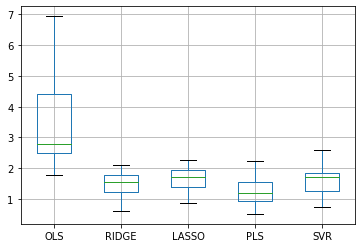

In [18]:
#Results in a boxplot
rmse_results.boxplot()